In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import pandas as pd
import pingouin as pg
import seaborn as sns
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import sys

from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    
    
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


In [2]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Read data

In [3]:
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et.csv')
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

overview = pd.DataFrame(
    [
        [len(data_et)],
        [len(data_trial)],
        [len(data_subject)]
    ], 
    columns=['length'],
    index=[
        'data_et', 
        'data_trial', 
        'data_subject'
          ]
)
print(overview)

              length
data_et       725392
data_trial     35796
data_subject      92


# Create datasets

## Position index

In [4]:
def addPositionIndex(data):
    data['positionIndex'] = 0

    x_pos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.35, 0.65, 0.35, 0.65]
    y_pos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8, 0.35, 0.35, 0.65, 0.65]

    for i in range(0, len(x_pos)):
        data.loc[(data['x_pos']==x_pos[i]) & (data['y_pos']==y_pos[i]), 'positionIndex']=i
    return data

data_trial = addPositionIndex(data_trial)

data_trial.loc[
    (data_trial['trial_type']=='eyetracking-calibration'), ['x_pos', 'y_pos', 'positionIndex']] \
    .drop_duplicates() \
    .sort_values(by='positionIndex')

,x_pos,y_pos,positionIndex
41,0.20,0.20,0
27,0.50,0.20,1
17,0.80,0.20,2
21,0.20,0.50,3
37,0.50,0.50,4
33,0.80,0.50,5
39,0.20,0.80,6
31,0.50,0.80,7
29,0.80,0.80,8
25,0.35,0.35,9


## Glasses binary

In [5]:
data_subject['glasses_binary'] = data_subject['sight'] \
    .replace({'contactLenses': 0, 
             'glasses': 1,
             'notCorrected': 0,
             'perfectSight': 0}
           )
print(data_subject['glasses_binary'].unique())

for col in ['glasses', 'sight', 'glasses_binary']:
    print(pd.crosstab(index=data_subject[col], columns="count"))
    print('\n')

[ 1.  0. nan]
col_0         count
glasses            
longSight        10
noCorrection     35
progressive       2
shortSight       18


col_0          count
sight               
contactLenses      5
glasses           24
notCorrected       3
perfectSight      33


col_0           count
glasses_binary       
0.0                41
1.0                24




## data_et

In [6]:
def add_var_to_data_et(data_et, source_data, varName):
    if varName in data_et.columns: data_et=data_et.drop(columns=varName)
    data_et = data_et.merge(
        source_data.loc[:, ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    return data_et

data_et = add_var_to_data_et(data_et, data_trial, 'task_nr')
data_et = add_var_to_data_et(data_et, data_trial, 'chin')
data_et = add_var_to_data_et(data_et, data_trial, 'chinFirst')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_type')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_duration')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_duration_exact')
data_et = add_var_to_data_et(data_et, data_trial, 'x_pos')
data_et = add_var_to_data_et(data_et, data_trial, 'y_pos')
data_et = add_var_to_data_et(data_et, data_trial, 'window_width')
data_et = add_var_to_data_et(data_et, data_trial, 'window_height')

## data_trial

In [7]:
if 'glasses_binary' in data_trial.columns:
    data_trial = data_trial.drop(columns=['glasses_binary'])
data_trial = data_trial.merge(
    data_subject.loc[:, ['run_id', 'glasses_binary']],
    on='run_id',
    how='left'
)

## data_et_fix

In [8]:
data_et_fix = data_et.loc[
    (data_et['trial_type']=='eyetracking-fix-object') &
    (data_et['trial_duration']==5000) &
    (data_et['t_task']>1000),     :
]

## data_trial_fix

In [9]:
data_trial_fix = data_trial.loc[
    (data_trial['trial_type']=='eyetracking-fix-object') &
    (data_trial['trial_duration']==5000),     :
].drop(columns=[
    'trial_type', 'trial_duration', 
    'choiceTask_amountLeftFirst',
    'option_topLeft', 'option_bottomLeft',
    'option_topRight', 'option_bottomRight',
    'chosenAmount', 'chosenDelay']
      )

# Screening

## Visually impaired without aids? 

In [10]:
subjects_cannotSee = data_subject.loc[
    (data_subject['sight'] == 'notCorrected') & 
    (data_subject['glasses'] == 'longSight'),
    'run_id']
subjects_cannotSee

48    28
Name: run_id, dtype: int64

## Not enough trials

In [11]:
NTrials = data_trial.groupby(['run_id'])['trial_index'].max() \
    .reset_index()
subjects_notEnoughTrials = NTrials.loc[NTrials['trial_index']<400, 'run_id']
print('These subjects do not have enough trials: \n' + 
      str(NTrials.loc[NTrials['trial_index']<400, :])
     )

These subjects do not have enough trials: 
    run_id  trial_index
27      61        271.0
46     125         15.0
51     141         19.0
61     162        131.0


In [12]:
temp = data_trial_fix.groupby(['run_id'])['trial_index'].max() \
    .reset_index()
subjects_notEnoughTrials_fix = temp.loc[temp['trial_index']<131, 'run_id']
temp.loc[temp['trial_index']<131, :]

,run_id,trial_index
27,61,130.0
31,70,130.0


In [13]:
subjects_notEnoughTrials = list(
    set(subjects_notEnoughTrials) | 
    set(subjects_notEnoughTrials_fix)
)
subjects_notEnoughTrials

[162, 61, 141, 70, 125]

## Not following intructions 

In [14]:
data_subject.loc[
    (data_subject['keptHead']==0) |
    (data_subject['triedChin']==0), 
    ['run_id', 'prolificID', 'keptHead', 'triedChin']
]

,run_id,prolificID,keptHead,triedChin
5,12,5b8969006651ea000118e42e,1.0,0.0
60,48,5fa1192cf99e161a5cfad1cd,1.0,0.0
82,9,5fea6632bf9ae4a79153efdf,1.0,0.0


In [15]:
subjects_noInstruction = data_subject.loc[
    (data_subject['keptHead']==0) |
    (data_subject['triedChin']==0), 
    'run_id'
].reset_index(drop=True)

## High t_task

In [16]:
data_et_fix.loc[data_et_fix['t_task']>5500, :] \
    .groupby(['run_id'])['x'].count()

run_id
1.0      27
9.0      37
70.0     18
80.0     18
97.0     29
183.0     8
Name: x, dtype: int64

In [17]:
data_trial_fix.loc[data_trial_fix['trial_duration_exact']>5500, :] \
    .groupby(['run_id', 'trial_index']).mean() \
    .reset_index() \
    .loc[:, ['run_id', 'trial_index', 'trial_duration_exact']]

,run_id,trial_index,trial_duration_exact
0,1,106.0,6337.0
1,1,109.0,6371.0
2,1,112.0,6296.0
3,1,115.0,6318.0
4,1,118.0,6310.0
...,...,...,...
96,183,257.0,7779.0
97,183,261.0,6896.0
98,183,265.0,6889.0
99,183,269.0,6940.0


## Not approved by prolific

In [18]:
data_subject.loc[
    ~data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC']),
    :
]

,run_id,birthyear,browliner,browser,browser_version,degree,device,ethnic,eyeliner,eyeshadow,...,Country of Birth,Current Country of Residence,Employment Status,First Language,Nationality,Sex,Student Status,Webcam,fps,glasses_binary
15,144,1997.0,0.0,Safari,14.0.3,college,Macintosh,caucasian,0.0,0.0,...,United States,United States,Part-Time,English,United States,Female,Yes,Yes,17.503355,0.0
16,146,1997.0,0.0,Chrome,88.0.4324.150,college,Macintosh,asian,0.0,0.0,...,India,United States,Other,NaN,India,Female,Yes,Yes,17.295826,0.0
20,150,1991.0,0.0,Chrome,88.0.4324.150,grad,WebKit,asian,1.0,0.0,...,Bangladesh,United States,Full-Time,Bengali,Bangladesh,Female,No,Yes,20.021312,1.0
21,151,1996.0,0.0,Chrome,88.0.4324.150,college,WebKit,asian,0.0,0.0,...,Nepal,United States,DATA EXPIRED,Nepali,Nepal,Female,Yes,Yes,8.051746,1.0
22,152,1998.0,0.0,Chrome,87.0.4280.141,college,Macintosh,caucasian,0.0,0.0,...,United States,United States,Part-Time,DATA EXPIRED,United States,Female,Yes,Yes,14.911969,0.0
23,153,1958.0,0.0,Chrome,88.0.4324.153,high,WebKit,asian,0.0,0.0,...,Bangladesh,United States,"Not in paid work (e.g. homemaker', 'retired or...",DATA EXPIRED,Bangladesh,Male,No,Yes,5.873565,1.0
24,154,1980.0,0.0,Chrome,88.0.4324.150,college,WebKit,asian,0.0,0.0,...,United States,United States,Full-Time,NaN,India,Male,No,Yes,20.279893,0.0
26,157,1993.0,0.0,Chrome,88.0.4324.150,NaN,WebKit,caucasian,0.0,0.0,...,United States,United States,Other,NaN,United States,Female,Yes,Yes,7.982667,1.0
27,160,1946.0,0.0,Chrome,88.0.4324.146,college,WebKit,caucasian,0.0,0.0,...,Netherlands,United States,"Not in paid work (e.g. homemaker', 'retired or...",Dutch,Netherlands,Male,No,Yes,23.642608,1.0
29,162,NaN,NaN,Firefox,85.0,NaN,NaN,NaN,NaN,NaN,...,United States,United States,Full-Time,DATA EXPIRED,Italy,Male,Yes,Yes,15.858163,NaN


In [19]:
subjects_notApproved = data_subject.loc[
    ~data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC']),
    'run_id'
]
subjects_notApproved

15    144
16    146
20    150
21    151
22    152
23    153
24    154
26    157
27    160
29    162
30    163
31    164
32    165
33    166
35    171
38    176
39    177
41    179
42    180
Name: run_id, dtype: int64

# Cleaning

In [20]:
excludedSubjects = list(
    set(subjects_notEnoughTrials) | 
    set(subjects_noInstruction) |
    set(subjects_notApproved) |
    set(subjects_cannotSee)
)
excludedSubjects

[70,
 9,
 12,
 141,
 144,
 146,
 150,
 151,
 152,
 153,
 154,
 28,
 157,
 160,
 162,
 163,
 164,
 165,
 166,
 171,
 48,
 176,
 177,
 61,
 179,
 180,
 125]

## data_subject variables

In [21]:
data_subject['degree'] = data_subject['degree'].replace({'0': np.nan, '-3.0': np.nan})
data_subject['webcam_fps'] = np.round(data_subject['webcam_fps'])

In [22]:
data_subject = data_subject.loc[~data_subject['run_id'].isin(excludedSubjects), :]
print(data_subject['run_id'].unique())

[  1 103 106 108  11 124 126 128  13 130 131  14 147 148 149 156 161 168
 172 173 178 181 183  19  24  25  30  32  36  37  38   4  41  42  43  45
  47  49   5  54  56  58  59   6  63  66  67   7  72  74  75  80  81  83
  85  88  90  91  92  93  94  96  97  98  99]


## Trial data

In [23]:
def cleanTrialData(data):
    print('raw data: ' + str(len(data)))
    data = data \
        .loc[~data['run_id'].isin(excludedSubjects), :] \
        .reset_index(drop=True)
    print('cleaned data: ' + str(len(data)))
    return data

print('data_trial')
data_trial = cleanTrialData(data_trial)
print('\n data_trial_fix')
data_trial_fix = cleanTrialData(data_trial_fix)

data_trial
raw data: 35796
cleaned data: 23225

 data_trial_fix
raw data: 1231
cleaned data: 810


## Eyetracking data
Exclude subjects, and trials with high duration

In [24]:
def cleanETData(data):
    print('raw data: ' + str(len(data)))
    data = data \
        .loc[~data['run_id'].isin(excludedSubjects), :] \
        .reset_index(drop=True)
    print('cleaned data: ' + str(len(data)))
    return data

print('data_et')
data_et = cleanETData(data_et)

print('\n data_et_fix')
data_et_fix = cleanETData(data_et_fix)
data_et_fix = data_et_fix.loc[
    data_et_fix['t_task']<5000,
    :
]

data_et
raw data: 725392
cleaned data: 468014

 data_et_fix
raw data: 74468
cleaned data: 50628


# Offset

## Calculate on gaze point-level

In [25]:
def euclideanDistance(x, x_target, y, y_target):
    x_diff = x - x_target
    y_diff = y - y_target
    euclideanDistance = np.sqrt(x_diff**2 + y_diff**2)
    return(euclideanDistance)

data_et.loc[:, "offset"] = euclideanDistance(
        data_et["x"], data_et['x_pos'],
        data_et["y"], data_et['y_pos'])
data_et_fix.loc[:, "offset"] = euclideanDistance(
        data_et_fix["x"], data_et_fix['x_pos'],
        data_et_fix["y"], data_et_fix['y_pos'])

Offset as pixels

In [26]:
data_et.loc[:, "offset_px"] = euclideanDistance(
    (data_et["x"] * data_et['window_width']), 
    (data_et['x_pos'] * data_et['window_width']),
    (data_et["y"] * data_et['window_height']), 
    (data_et['y_pos'] * data_et['window_height'])
)
data_et_fix.loc[:, "offset_px"] = euclideanDistance(
    (data_et_fix["x"] * data_et_fix['window_width']), 
    (data_et_fix['x_pos'] * data_et_fix['window_width']),
    (data_et_fix["y"] * data_et_fix['window_height']), 
    (data_et_fix['y_pos'] * data_et_fix['window_height'])
)
data_et['offset_px'].describe()

count    349578.000000
mean        212.698788
std         270.658099
min           0.106456
25%          78.338574
50%         143.692332
75%         271.762910
max       28337.164309
Name: offset_px, dtype: float64

In [27]:
print(data_et[['offset', 'offset_px']].describe())
print(data_et_fix[['offset', 'offset_px']].describe())

              offset      offset_px
count  349578.000000  349578.000000
mean        0.171368     212.698788
std         0.211410     270.658099
min         0.000117       0.106456
25%         0.064417      78.338574
50%         0.119186     143.692332
75%         0.222776     271.762910
max        29.665425   28337.164309
             offset     offset_px
count  50350.000000  50350.000000
mean       0.160075    194.316832
std        0.148860    170.655583
min        0.000452      0.908491
25%        0.070054     86.087428
50%        0.118777    145.879578
75%        0.200028    248.139751
max        1.621144   2313.307199


## Plot: gaze shift within a trial

In [28]:
def select_fixTask_and_fixCross(data):
    return data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        ((data['task_nr']==1) |
            ((data['chinFirst']==0) & (data['task_nr']==2)) |
            ((data['chinFirst']==1) & (data['task_nr']==3))
        ), :]. reset_index(drop=True)

def reformatTTask(data):                                                 
    data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        (data['trial_duration']==1500), 
        't_task'
    ] = data.loc[
        (data['trial_type']=='eyetracking-fix-object') &
        (data['trial_duration']==1500), 
        't_task'
    ] - 1500
    return data


data_et_fix_task_fixCross = reformatTTask(select_fixTask_and_fixCross(data_et))

def add_next_xy_pos(data):
    data['next_x_pos']=0
    data['next_y_pos']=0
    for i in data.index:
        if data.loc[i, 'trial_duration']==1500:
            data.loc[i, 'next_x_pos'] = data.loc[i+1, 'x_pos']
            data.loc[i, 'next_y_pos'] = data.loc[i+1, 'y_pos']
    return(data)

data_trial_fix_task_fixCross = add_next_xy_pos(select_fixTask_and_fixCross(data_trial))

data_et_fix_task_fixCross = data_et_fix_task_fixCross.merge(
    data_trial_fix_task_fixCross.loc[:, ['run_id', 'trial_index', 'next_x_pos', 'next_y_pos']],
    on=['run_id', 'trial_index'],
    how='left'
)

In [29]:
def new_distance_for_fixCross(data):
    data.loc[data['trial_duration']==1500, 'offset'] = euclideanDistance(
        data.loc[data['trial_duration']==1500, 'x'], 
        data.loc[data['trial_duration']==1500, 'next_x_pos'], 
        data.loc[data['trial_duration']==1500, 'y'], 
        data.loc[data['trial_duration']==1500, 'next_y_pos']
    )
    return data
        
data_et_fix_task_fixCross = new_distance_for_fixCross(data_et_fix_task_fixCross)

In [30]:
def createAVGLine(data):
    binArray = np.arange(-1500, 5000, 50)
    bins = pd.cut(data['t_task'], binArray)
    output = data.groupby(bins).agg({"offset": "median"}).reset_index()
    output['t_task'] = binArray[0:len(output)]
    return output

average_line_noChin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==0, :])
average_line_chin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==1, :])

Text(0.5, 0, 't_task')

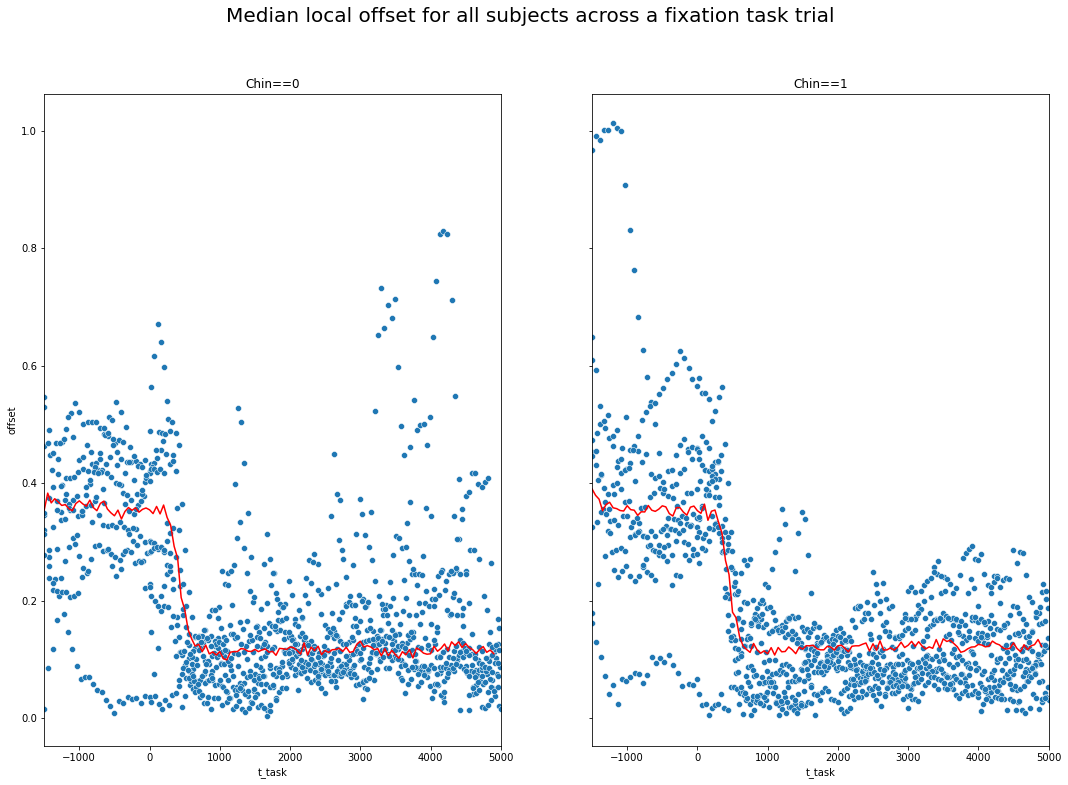

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18, 12))
fig.suptitle('Median local offset for all subjects across a fixation task trial', fontsize=20)

axes[0].set_title("Chin==0")
axes[1].set_title("Chin==1")

sns.scatterplot(ax=axes[0], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==0), 
                    :], 
                x="t_task", y="offset")
sns.lineplot(ax=axes[0], x=average_line_noChin['t_task'], y=average_line_noChin['offset'], color='r')

sns.scatterplot(ax=axes[1], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==1), 
                    :],
                x="t_task", y="offset")
sns.lineplot(ax=axes[1], x=average_line_chin['t_task'], y=average_line_chin['offset'], color='r')

plt.setp(axes, xlim=(-1500, 5000)) 
plt.xlabel("t_task")

## Aggregate on trial level

In [32]:
def merge_varMean_by_index(data, data_et, varName):
    if varName in data.columns: 
        data = data.drop(columns=[varName])
    grouped = data_et.groupby(['run_id', 'trial_index'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left')
    return data

data_trial = merge_varMean_by_index(data_trial, data_et, 'offset')
data_trial_fix = merge_varMean_by_index(data_trial_fix, data_et_fix, 'offset')
data_trial = merge_varMean_by_index(data_trial, data_et, 'offset_px')
data_trial_fix = merge_varMean_by_index(data_trial_fix, data_et_fix, 'offset_px')
data_trial_fix['offset']

0      0.126908
1      0.201564
2      0.163404
3      0.117219
4      0.166590
         ...   
805         NaN
806         NaN
807         NaN
808         NaN
809         NaN
Name: offset, Length: 810, dtype: float64

## Fixation task trial index

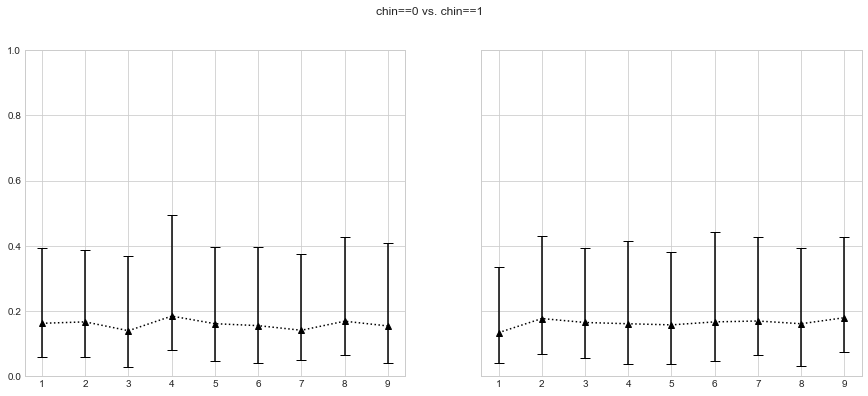

In [33]:
def group_chin_withinTaskIndex(data, varName):
    df_m = data.groupby(['chin', 'withinTaskIndex']) \
        [varName].median() \
        .reset_index() \
        .rename(columns={varName: varName + '_median'}) \
        .reset_index()

    data = data.merge(df_m, on=['chin', 'withinTaskIndex'], how='left')
    data['above_median'] = data[varName] > data[varName + '_median']
    
    df_std_upper = data.loc[data['above_median']==1, :] \
        .groupby(['chin', 'withinTaskIndex'])[varName].median() \
        .reset_index() \
        .rename(columns={varName: varName + '_std_upper'}) \
        .reset_index()
    df_std_lower = data.loc[data['above_median']==0, :] \
        .groupby(['chin', 'withinTaskIndex'])[varName].median() \
        .reset_index() \
        .rename(columns={varName: varName + '_std_lower'}) \
        .reset_index()

    output = pd.concat([
        df_m, 
        df_std_upper[varName + '_std_upper'],
        df_std_lower[varName + '_std_lower']
    ], axis=1)
    return output


data_plot = group_chin_withinTaskIndex(
    data_trial.loc[data_trial['fixTask']==1, :],
    'offset'
)

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chin==0 vs. chin==1')

ax[0].set_ylim(0, 1)

for i in [0, 1]:
    data = data_plot.loc[data_plot['chin']==i, :]
    ax[i].errorbar(
        x = data['withinTaskIndex'], 
        y = data['offset_median'],
        yerr=[data['offset_std_lower'], data['offset_std_upper']],
        fmt='^k:',
        capsize=5
    )
plt.show()

## Fixation positions

In [34]:
data_trial_fix.groupby(['x_pos', 'y_pos']) \
    ['offset'].median() \
    .reset_index()

,x_pos,y_pos,offset
0,0.2,0.2,0.172345
1,0.2,0.5,0.129736
2,0.2,0.8,0.168046
3,0.5,0.2,0.148219
4,0.5,0.5,0.106299
5,0.5,0.8,0.100364
6,0.8,0.2,0.156546
7,0.8,0.5,0.116212
8,0.8,0.8,0.145581


## Aggregate on subject-level 

In [35]:
def merge_by_subject(data, large_data, varName):
    if varName in data.columns: data = data.drop(columns=[varName])
    grouped = large_data.groupby(['run_id'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id'], how='left')
    return data

data_subject = merge_by_subject(data_subject, data_trial_fix, 'offset')
data_subject = merge_by_subject(data_subject, data_trial_fix, 'offset_px')

In [36]:
def separate_outcomes_by_condition(data, large_data, varName, varCondition):
    var_cond_0 = varName + '_' + varCondition + '_0' 
    var_cond_1 = varName + '_' + varCondition + '_1' 
    
    if var_cond_0 in data.columns: 
        data = data.drop(columns=[var_cond_0])
    if var_cond_1 in data.columns: 
        data = data.drop(columns=[var_cond_1])
        
    grouped = large_data \
        .groupby(['run_id', varCondition])[varName].mean() \
        .reset_index() \
        .pivot(index='run_id', columns=varCondition, values=varName) \
        .reset_index() \
        .rename(columns={0.0: var_cond_0, 1.0: var_cond_1}) 
    data = data.merge(grouped.loc[:, ['run_id', var_cond_0, var_cond_1]], on='run_id', how='left')
    return data

data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'offset', 'chin')

data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'offset', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'offset', 'offset_chin_0', 'offset_chin_1',
        'offset_glasses_binary_0', 'offset_glasses_binary_1'
    ]
].describe()

,offset,offset_chin_0,offset_chin_1,offset_glasses_binary_0,offset_glasses_binary_1
count,40.000000,40.000000,40.000000,27.000000,11.000000
mean,0.182139,0.180790,0.183489,0.173343,0.192804
std,0.127520,0.132828,0.130843,0.145769,0.068412
min,0.074476,0.069445,0.058743,0.074476,0.093744
25%,0.106042,0.092625,0.107622,0.097317,0.151479
50%,0.145377,0.145796,0.145601,0.128306,0.194021
75%,0.212159,0.212404,0.201283,0.169751,0.231292
max,0.803838,0.802732,0.804944,0.803838,0.320545


In [37]:
data_subject = separate_outcomes_by_condition(data_subject, data_trial_fix, 'offset_px', 'chin')
data_subject = separate_outcomes_by_condition(data_subject, data_trial_fix, 'offset_px', 'glasses_binary')

data_subject.loc[
    :, 
    [
        'offset_px', 'offset_px_chin_0', 'offset_px_chin_1',
        'offset_px_glasses_binary_0', 'offset_px_glasses_binary_1'
    ]
].describe()

,offset_px,offset_px_chin_0,offset_px_chin_1,offset_px_glasses_binary_0,offset_px_glasses_binary_1
count,40.000000,40.000000,40.000000,27.000000,11.000000
mean,218.414927,218.893457,217.936396,200.996975,242.620584
std,144.205770,160.901826,142.283715,152.978546,93.942521
min,83.736683,60.366083,67.152923,83.736683,104.361130
25%,121.575040,115.689388,125.521744,107.362952,187.866550
50%,174.132377,170.102478,182.185218,163.411497,237.322511
75%,276.225932,268.042720,247.059571,237.388630,289.476766
max,847.965209,848.277618,847.652800,847.965209,440.137137


## Grand mean offset

In [38]:
grouped = data_et_fix.groupby(['run_id', 'trial_index']) \
    ['x', 'y'].mean() \
    .reset_index() \
    .rename(columns={'x': 'x_mean', 'y': 'y_mean'})

if 'x_mean' in data_trial_fix.columns:
    data_trial_fix = data_trial_fix.drop(columns=['x_mean'])
if 'y_mean' in data_trial_fix.columns:
    data_trial_fix = data_trial_fix.drop(columns=['y_mean'])    
data_trial_fix = data_trial_fix.merge(
    grouped,
    on=['run_id', 'trial_index'],
    how='left'
) 
data_trial_fix['x_mean_px'] = data_trial_fix['x_mean'] * data_trial_fix['window_width']
data_trial_fix['y_mean_px'] = data_trial_fix['y_mean'] * data_trial_fix['window_height']
data_trial_fix.loc[:, ['x_mean', 'x_mean_px', 'y_mean', 'y_mean_px']].describe()

<ipython-input-38-066a389a9d25>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data_et_fix.groupby(['run_id', 'trial_index']) \


,x_mean,x_mean_px,y_mean,y_mean_px
count,720.000000,720.000000,720.000000,720.000000
mean,0.503562,817.015630,0.496324,457.477182
std,0.230754,414.898379,0.210095,217.523219
min,-0.128611,-175.682599,-0.119720,-129.298115
25%,0.311128,540.199985,0.343912,305.179942
50%,0.509268,781.265983,0.511126,448.673207
75%,0.702996,1073.653187,0.652723,592.223419
max,1.033191,2282.782704,0.953577,1126.277549


In [39]:
data_trial_fix['grand_deviation'] = euclideanDistance(
    data_trial_fix['x_mean'], data_trial_fix['x_pos'],
    data_trial_fix['y_mean'], data_trial_fix['y_pos']
)
data_trial_fix['grand_deviation'].describe()

count    720.000000
mean       0.167906
std        0.159360
min        0.003546
25%        0.068729
50%        0.121585
75%        0.213770
max        1.287244
Name: grand_deviation, dtype: float64

# Precision

## Distance from AVG on et-level

In [40]:
def merge_xy_means(data):    
    grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \
        .rename(columns={'x': 'x_mean', 'y': 'y_mean'})
    
    if 'x_mean' in data.columns: 
        data = data.drop(columns=['x_mean'])
    if 'y_mean' in data.columns: 
        data = data.drop(columns=['y_mean'])
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left') 
    return(data)

def distanceFromAVG_square(data):
    data = merge_xy_means(data)
    data['distanceFromAVG_square'] = np.power(
        euclideanDistance(data['x'], data['x_mean'], data['y'], data['y_mean']),
        2
    )
    data['distanceFromAVG_square_px'] = np.power(euclideanDistance(
        (data['x'] * data_et['window_width']), 
        (data['x_mean'] * data_et['window_width']), 
        (data['y'] * data_et['window_height']), 
        (data['y_mean'] * data_et['window_height'])
    ), 2)
    
    return(data)  

data_et = distanceFromAVG_square(data_et)
data_et_fix = distanceFromAVG_square(data_et_fix)
print(data_et_fix.loc[
    pd.isna(data_et_fix['distanceFromAVG_square']), 
    ['x', 'y', 'x_pos', 'y_pos', 'distanceFromAVG_square']
])
data_et_fix.loc[
    :, ['distanceFromAVG_square', 'distanceFromAVG_square_px']] \
    .describe()

<ipython-input-40-ca53af98e2a3>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \


Empty DataFrame
Columns: [x, y, x_pos, y_pos, distanceFromAVG_square]
Index: []


,distanceFromAVG_square,distanceFromAVG_square_px
count,5.035000e+04,50350.000000
mean,7.590325e-03,9043.794938
std,2.102691e-02,24753.677147
min,1.693024e-07,0.109913
25%,9.359214e-04,1050.314501
50%,2.631076e-03,3022.370117
75%,6.790078e-03,7847.089190
max,7.066435e-01,844580.968563


## Aggregate standard deviation on trial-level

In [41]:
data_trial = merge_varMean_by_index(
    data_trial, data_et, 'distanceFromAVG_square')
data_trial['precision'] = np.sqrt(data_trial['distanceFromAVG_square'])

data_trial_fix = merge_varMean_by_index(
    data_trial_fix, data_et_fix, 'distanceFromAVG_square')
data_trial_fix['precision'] = np.sqrt(data_trial_fix['distanceFromAVG_square'])
print(data_trial_fix['precision'].describe())

count    720.000000
mean       0.076108
std        0.041521
min        0.002455
25%        0.049993
50%        0.066364
75%        0.091665
max        0.401964
Name: precision, dtype: float64


In pixel

In [42]:
data_trial = merge_varMean_by_index(
    data_trial, data_et, 'distanceFromAVG_square_px')
data_trial['precision_px'] = np.sqrt(data_trial['distanceFromAVG_square_px'])

data_trial_fix = merge_varMean_by_index(
    data_trial_fix, data_et_fix, 'distanceFromAVG_square_px')
data_trial_fix['precision_px'] = np.sqrt(data_trial_fix['distanceFromAVG_square_px'])
print(data_trial_fix['precision_px'].describe())

count    720.000000
mean      83.658947
std       49.879023
min        2.707271
25%       53.438083
50%       70.460760
75%       97.802533
max      429.945888
Name: precision_px, dtype: float64


Any missing values?

In [43]:
data_trial_fix.loc[
    pd.isna(data_trial_fix['precision']), 
    ['run_id', 'trial_index', 'x_pos', 'y_pos', 'precision']
]

,run_id,trial_index,x_pos,y_pos,precision
288,38,106.0,0.2,0.8,NaN
289,38,109.0,0.5,0.5,NaN
290,38,112.0,0.8,0.5,NaN
291,38,115.0,0.2,0.5,NaN
292,38,118.0,0.5,0.2,NaN
...,...,...,...,...,...
805,98,243.0,0.8,0.2,NaN
806,98,246.0,0.2,0.8,NaN
807,98,249.0,0.2,0.5,NaN
808,98,252.0,0.5,0.5,NaN


## Precision across trials

In [44]:
data_plot = group_chin_withinTaskIndex(
    data_trial.loc[data_trial['fixTask']==1, :],
    'precision'
)
data_plot

,index,chin,withinTaskIndex,precision_median,precision_std_upper,precision_std_lower
0,0,0.0,1.0,0.116540,0.137069,0.096341
1,1,0.0,2.0,0.103633,0.147788,0.079404
2,2,0.0,3.0,0.105974,0.120133,0.083322
3,3,0.0,4.0,0.113369,0.141467,0.092514
4,4,0.0,5.0,0.114619,0.138544,0.099379
5,5,0.0,6.0,0.115544,0.134322,0.086333
6,6,0.0,7.0,0.099690,0.127218,0.076726
7,7,0.0,8.0,0.113026,0.138389,0.084493
8,8,0.0,9.0,0.108020,0.137460,0.090981
9,9,1.0,1.0,0.108985,0.137692,0.076689


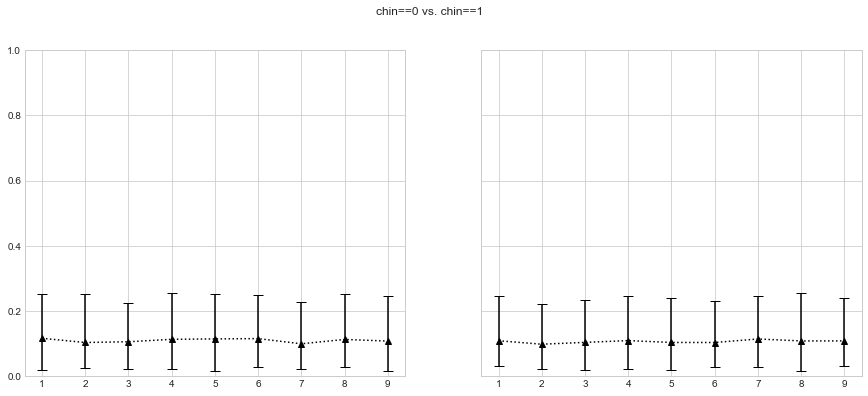

In [45]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chin==0 vs. chin==1')

ax[0].set_ylim(0, 1)

for i in [0, 1]:
    data = data_plot.loc[data_plot['chin']==i, :]
    ax[i].errorbar(
        x = data['withinTaskIndex'], 
        y = data['precision_median'],
        yerr=[data['precision_std_lower'], data['precision_std_upper']],
        fmt='^k:',
        capsize=5
    )
plt.show()

## Aggregate on subject-level 

In [46]:
data_subject = merge_by_subject(data_subject, data_trial_fix, 'precision')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision', 'chin')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'precision', 'precision_chin_0', 'precision_chin_1',
        'precision_glasses_binary_0', 'precision_glasses_binary_1'
    ]
].describe()

,precision,precision_chin_0,precision_chin_1,precision_glasses_binary_0,precision_glasses_binary_1
count,40.000000,40.000000,40.000000,27.000000,11.000000
mean,0.076108,0.078703,0.073513,0.069863,0.096476
std,0.026279,0.024065,0.034612,0.017617,0.031896
min,0.020662,0.022359,0.018965,0.045083,0.065420
25%,0.057925,0.062935,0.053732,0.055098,0.072007
50%,0.072007,0.074608,0.065483,0.064958,0.092793
75%,0.090137,0.088878,0.084964,0.084865,0.102475
max,0.175707,0.138606,0.237169,0.105191,0.175707


In pixel

In [47]:
data_subject = merge_by_subject(data_subject, data_trial_fix, 'precision_px')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision_px', 'chin')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision_px', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'precision_px', 'precision_px_chin_0', 'precision_px_chin_1',
        'precision_px_glasses_binary_0', 'precision_px_glasses_binary_1'
    ]
].describe()

,precision_px,precision_px_chin_0,precision_px_chin_1,precision_px_glasses_binary_0,precision_px_glasses_binary_1
count,40.000000,40.000000,40.000000,27.000000,11.000000
mean,83.658947,86.387267,80.930628,76.908602,104.660538
std,34.420099,34.435715,39.331540,25.890342,43.886724
min,25.770470,29.979587,21.561353,42.566687,62.997529
25%,62.778708,67.362657,56.608486,59.259033,74.994621
50%,78.510741,76.822526,79.058040,73.410168,90.440850
75%,91.744154,92.303575,97.471075,86.337099,115.126487
max,202.306597,176.265853,252.321784,139.492633,202.306597


# chinFirst: Randomization worked? 

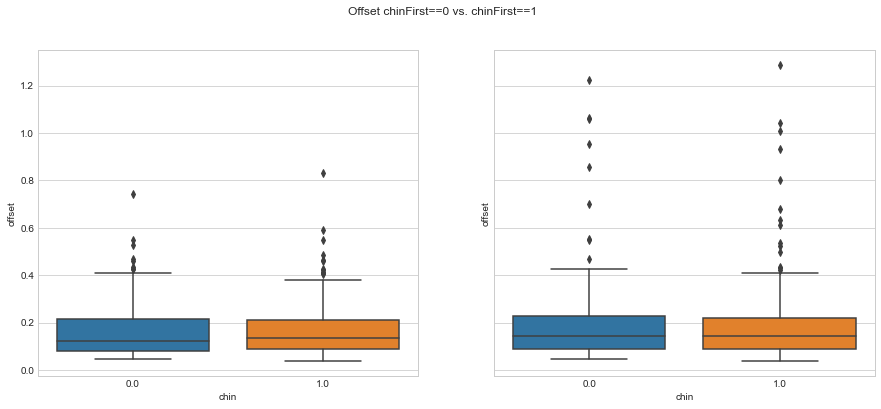

In [48]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

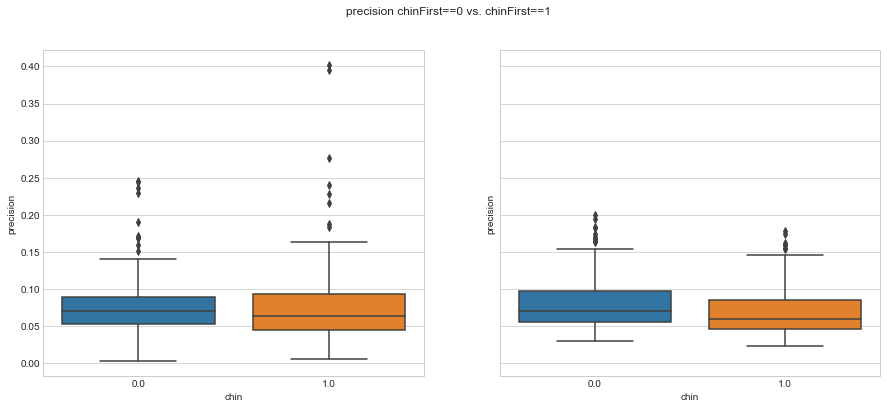

In [49]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('precision chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

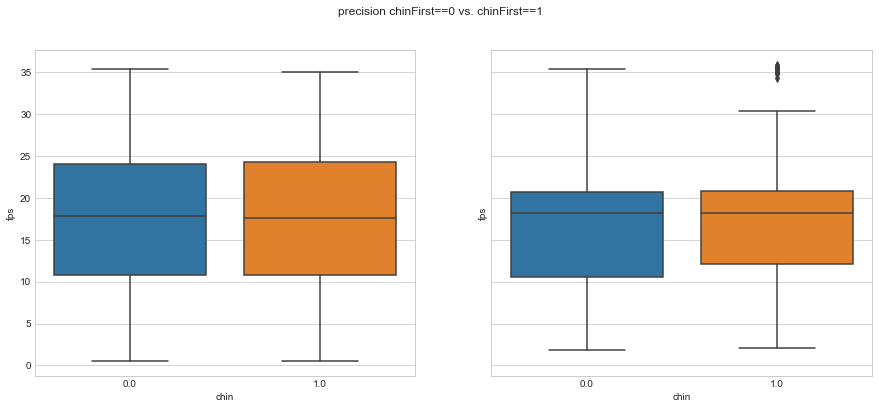

In [50]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('precision chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='fps', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='fps', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

# Main effect: chin-rest
 - t-tests will follow
 - TODO: Compare subjects with high fps (Semmelmann & Weigelt, 2019)

In [51]:
data_trial_fix['fps'].median()
data_trial_fix['high_fps']=0
data_trial_fix.loc[
    data_trial_fix['fps']>data_trial_fix['fps'].median(),
    'high_fps'
]=1

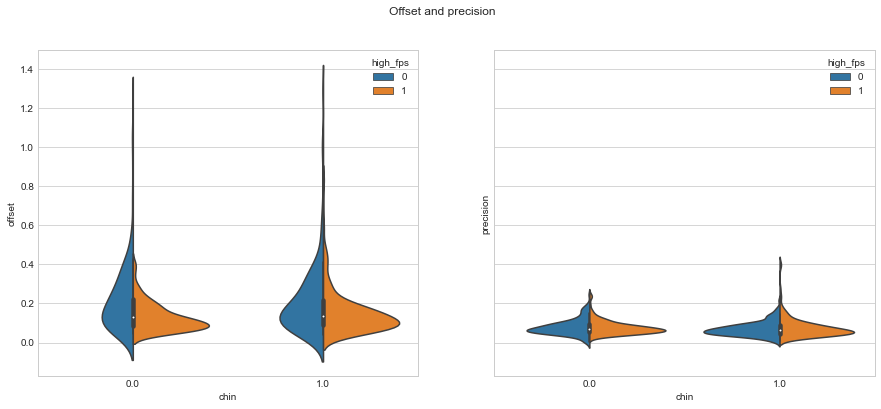

In [52]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset and precision')

sns.violinplot(ax=axes[0], 
               x='chin', 
               y='offset', 
               hue='high_fps',
               split=True,
               data=data_trial_fix)
sns.violinplot(ax=axes[1], 
               x='chin', 
               y='precision', 
               hue='high_fps',
               split=True,
               data=data_trial_fix)
   
plt.show()

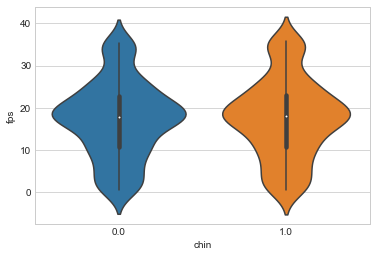

In [53]:
sns.violinplot(x='chin', y='fps', data=data_trial_fix)   
plt.show()

In [54]:
means_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].mean() \
    .reset_index() \
    .rename(columns={0: 'mean'})
var_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].var() \
    .reset_index() \
    .rename(columns={0: 'var'})
means_0.merge(var_0, on='index', how='left')

,index,mean,var
0,offset_chin_0,0.180790,0.017643
1,offset_chin_1,0.183489,0.017120
2,precision_chin_0,0.078703,0.000579
3,precision_chin_1,0.073513,0.001198


In [55]:
test_data = data_subject.loc[
    pd.notna(data_subject['offset_chin_0']) & 
    pd.notna(data_subject['offset_chin_1']), :]
scipy.stats.ttest_rel(test_data['offset_chin_0'], test_data['offset_chin_1'])

Ttest_relResult(statistic=-0.254945913166803, pvalue=0.8001045270027016)

## offset across fixation positions

In [56]:
data_trial_fix.groupby(['chin', 'x_pos', 'y_pos']) \
    ['offset'].mean() \
    .reset_index()

# rej, pval_corr = smm.multipletests(pval_raw, alpha=alpha, method='h')[:2]

,chin,x_pos,y_pos,offset
0,0.0,0.2,0.2,0.194703
1,0.0,0.2,0.5,0.168794
2,0.0,0.2,0.8,0.213910
3,0.0,0.5,0.2,0.178849
4,0.0,0.5,0.5,0.137602
5,0.0,0.5,0.8,0.159495
6,0.0,0.8,0.2,0.215480
7,0.0,0.8,0.5,0.164029
8,0.0,0.8,0.8,0.194250
9,1.0,0.2,0.2,0.191820


## Offset & precision across fixation dot positions

In [57]:
grouped_var = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].var() \
    .rename(columns={'offset': 'offset_var', 'precision':'precision_var'}) \
    .reset_index()

grouped_means = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].mean() \
    .reset_index()

grouped = grouped_means.merge(grouped_var, on=['positionIndex', 'chin'], how='left')

grouped_offset = grouped.loc[:, ['positionIndex', 'chin', 'offset']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_chin_0', 1.0: 'offset_chin_1'}) 

grouped_offset_var = grouped.loc[:, ['positionIndex', 'chin', 'offset_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset_var'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_var_chin_0', 1.0: 'offset_var_chin_1'}) 

grouped_precision = grouped.loc[:, ['positionIndex', 'chin', 'precision']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_chin_0', 1.0: 'precision_chin_1'}) 

grouped_precision_var = grouped.loc[:, ['positionIndex', 'chin', 'precision_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision_var'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_var_chin_0', 1.0: 'precision_var_chin_1'}) 

overview = pd.concat(
    [
        grouped_offset,
        grouped_offset_var.iloc[:, 1:3],
        grouped_precision.iloc[:, 1:3], 
        grouped_precision_var.iloc[:, 1:3]
    ], 
    axis=1
)

print(overview.mean(numeric_only=True))
overview

chin
positionIndex           4.000000
offset_chin_0           0.180790
offset_chin_1           0.183489
offset_var_chin_0       0.023304
offset_var_chin_1       0.024246
precision_chin_0        0.078703
precision_chin_1        0.073513
precision_var_chin_0    0.001378
precision_var_chin_1    0.002009
dtype: float64


<ipython-input-57-15d38b239ff3>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_var = data_trial_fix.groupby(['positionIndex', 'chin']) \
<ipython-input-57-15d38b239ff3>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_means = data_trial_fix.groupby(['positionIndex', 'chin']) \


chin,positionIndex,offset_chin_0,offset_chin_1,offset_var_chin_0,offset_var_chin_1,precision_chin_0,precision_chin_1,precision_var_chin_0,precision_var_chin_1
0,0,0.194703,0.191820,0.013721,0.012035,0.093187,0.078722,0.002054,0.001605
1,1,0.178849,0.175910,0.015290,0.013134,0.078023,0.074949,0.000997,0.001812
2,2,0.215480,0.184260,0.027337,0.019990,0.094939,0.085857,0.002066,0.001393
3,3,0.168794,0.177235,0.011490,0.018763,0.073150,0.076034,0.000772,0.002087
4,4,0.137602,0.131670,0.012267,0.011606,0.070153,0.062649,0.001427,0.000971
5,5,0.164029,0.178452,0.029102,0.027374,0.077423,0.070793,0.001161,0.001416
6,6,0.213910,0.230828,0.029831,0.037487,0.081526,0.074046,0.002190,0.003542
7,7,0.159495,0.173704,0.031399,0.031541,0.065423,0.066299,0.000770,0.001753
8,8,0.194250,0.207518,0.039296,0.046280,0.074500,0.072274,0.000961,0.003503


# Main effect: Visual Aid

## Frequency of visual aids

In [58]:
for col in ['glasses', 'sight', 'glasses_binary']:
    print(pd.crosstab(index=data_subject[col], columns="count"))
    print('\n')

col_0         count
glasses            
longSight         6
noCorrection     27
progressive       1
shortSight        9


col_0          count
sight               
contactLenses      3
glasses           13
perfectSight      27


col_0           count
glasses_binary       
0.0                30
1.0                13




## offset & precision on subject-level

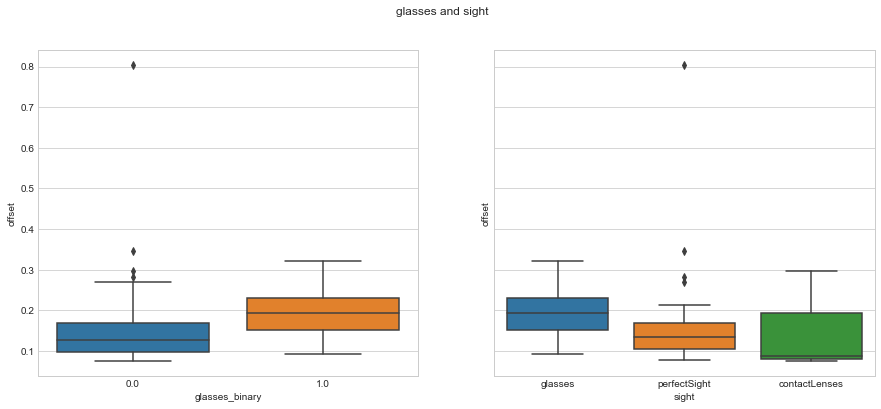

In [59]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('glasses and sight')

sns.boxplot(ax=axes[0], x='glasses_binary', y='offset', data=data_subject)
sns.boxplot(ax=axes[1], x='sight', y='offset', data=data_subject)
   
plt.show()

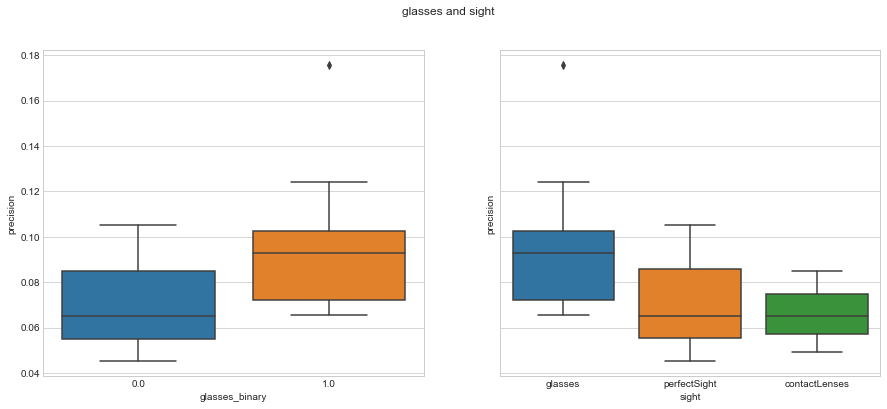

In [60]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('glasses and sight')

sns.boxplot(ax=axes[0], x='glasses_binary', y='precision', data=data_subject)
sns.boxplot(ax=axes[1], x='sight', y='precision', data=data_subject)
   
plt.show()

# Gaze predictions

## Gaze dot positions for each position

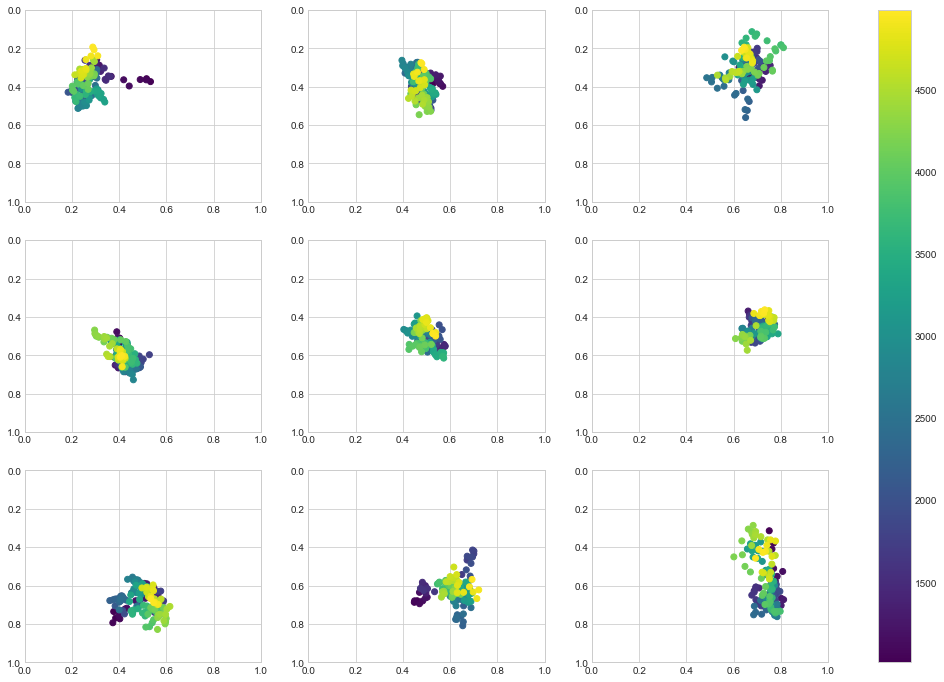

In [61]:
data_plot = add_var_to_data_et(data_et_fix, data_trial, 'chin')
data_plot = data_plot.loc[
    (data_plot['run_id']==43) & 
    (data_plot['chin']==0), :]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.ravel()
xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, 9):
    axes_data = data_plot.loc[(data_plot['x_pos']==xPos[i]) & (data_plot['y_pos']==yPos[i]), :]
    im = axes[i].scatter(
        axes_data['x'], 
        axes_data['y'], 
        c=axes_data['t_task'], 
        cmap='viridis'
    )
    axes[i].set_ylim(1, 0)
    axes[i].set_xlim(0, 1)
    
fig.colorbar(im, ax=axes)
plt.show()

## Heatmap

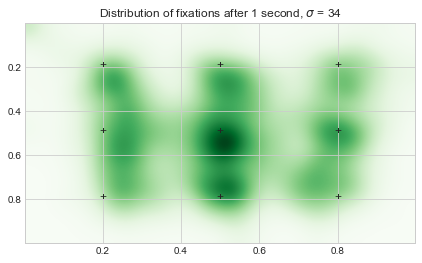

<Figure size 432x288 with 0 Axes>

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

x = data_et_fix.loc[
    (data_et_fix['x']>0) & (data_et_fix['x']<1) &
    (data_et_fix['y']>0) & (data_et_fix['y']<1),
    'x']

y = data_et_fix.loc[
    (data_et_fix['x']>0) & (data_et_fix['x']<1) &
    (data_et_fix['y']>0) & (data_et_fix['y']<1),
    'y']

def myplot(x, y, s, bins=[1200, 675]):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]
    return heatmap.T, extent

s=34
img, extent = myplot(x, y, s=s)

plt.figure(figsize=(7, 7))
plt.imshow(img, extent=extent, origin='upper', cmap=cm.Greens, aspect=(9/16))
plt.title("Distribution of fixations after 1 second, $\sigma$ = %d" % s)


xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, len(xPos)):
    plt.text(xPos[i], yPos[i], '+', size=12, ha="center")

plt.show()
plt.savefig('plots/fix_heatmap.png')

# Additional analyis

## Median offset across calibration trials
Does data quality improve during calibration? 

In [63]:
data_et_calibration = data_et.loc[data_et['trial_type']=='eyetracking-calibration', :]
data_trial_calibration = data_trial \
    .loc[data_trial['trial_type']=='eyetracking-calibration', :]

# Add median offset 
grouped = data_et_calibration \
    .groupby(['run_id', 'trial_index'])['offset'].median() \
    .reset_index() \
    .rename(columns={'offset': 'offset_median'}) 
data_trial_calibration = data_trial_calibration.merge(
    grouped,
    on=['run_id', 'trial_index'],
    how='left'
)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


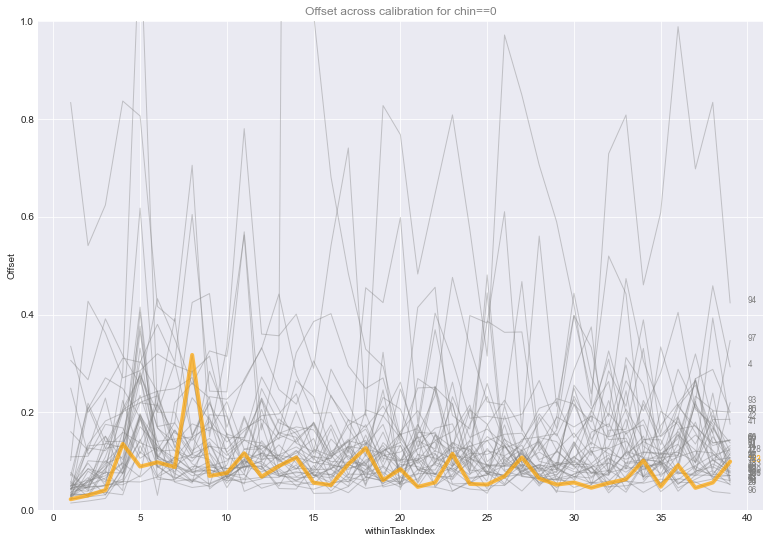

In [64]:
def spaghettiPlot(data, xVar, yVar, highlightedSubject):
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(13, 9))

    # Draw Plots
    for subject in data["run_id"].unique():
        ax.plot(data.loc[data['run_id']==subject, xVar], 
                data.loc[data['run_id']==subject, yVar], 
                marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(data.loc[data['run_id']==highlightedSubject, xVar], 
            data.loc[data['run_id']==highlightedSubject, yVar], 
            marker='', color='orange', linewidth=4, alpha=0.7)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

        else:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='orange')
    return plt

spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'offset_median', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


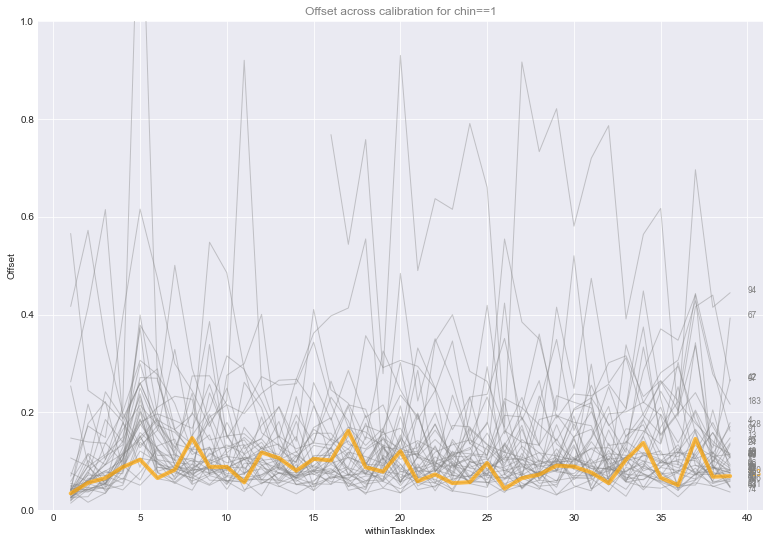

In [65]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'offset_median', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

## Median precision across calibration trials

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


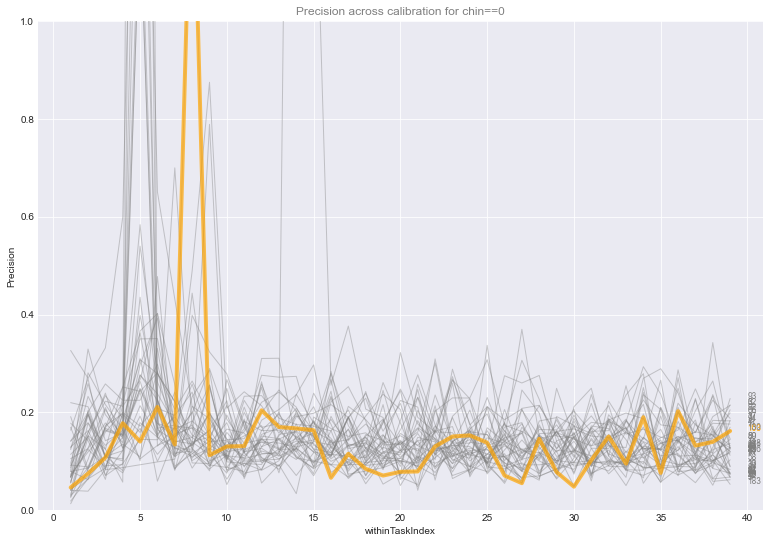

In [66]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


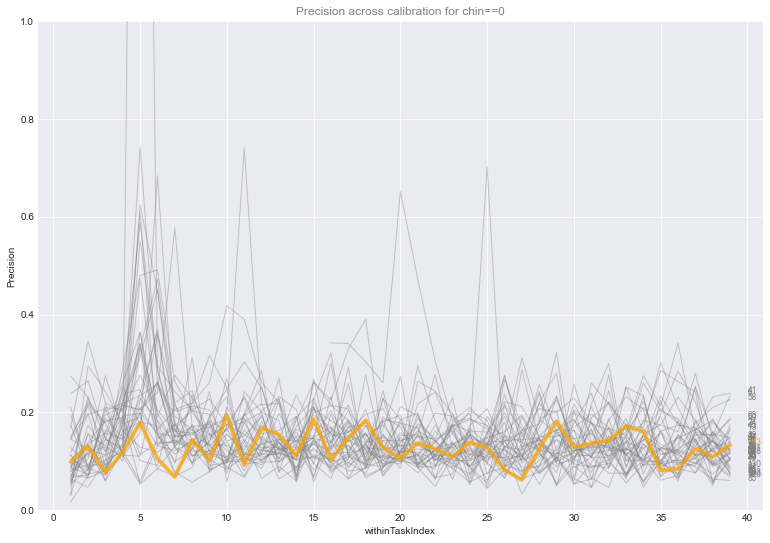

In [67]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

## Categorical confounders

In [68]:
predictors = [
    'vertPosition', 'gender', 'ethnic',  
    'degree', 'browser', 'glasses', 'sight', 'sight']  
for col in predictors:
    print(pd.crosstab(index=data_subject[col], columns="count"))
    print('\n')

col_0         count
vertPosition       
a                18
b                20
c                 5


col_0    count
gender        
diverse      1
female      12
male        30


col_0      count
ethnic          
asian          1
black          3
caucasian     35
hispanic       4


col_0    count
degree        
college     15
grad         9
high        13
middle       1


col_0    count
browser       
Chrome      51
Edge         2
Firefox      6
Opera        2
Safari       4


col_0         count
glasses            
longSight         6
noCorrection     27
progressive       1
shortSight        9


col_0          count
sight               
contactLenses      3
glasses           13
perfectSight      27


col_0          count
sight               
contactLenses      3
glasses           13
perfectSight      27




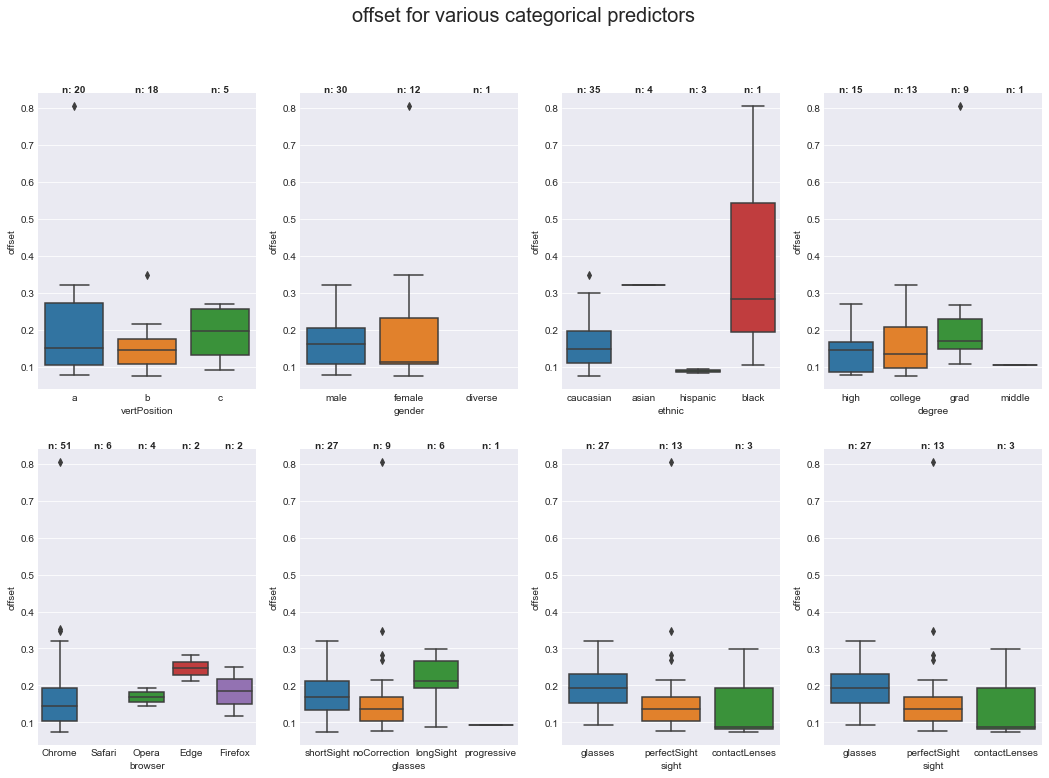

In [69]:
def getBoxPlots(outcome, yPos):
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 12))
    fig.suptitle(outcome + ' for various categorical predictors', fontsize=20)
    ax = ax.ravel()
    for i in range(0, 8):
        sns.boxplot(ax=ax[i], x=predictors[i], y=outcome, data=data_subject)
        nobs = data_subject[predictors[i]].value_counts().values
        nobs = [str(x) for x in nobs.tolist()]
        nobs = ["n: " + i for i in nobs]
        # Add it to the plot
        pos = range(len(nobs))
        for tick,label in zip(pos,ax[i].get_xticklabels()):
            ax[i].text(pos[tick], yPos, nobs[tick], # medians[tick] + 0.02
            verticalalignment='top',
            horizontalalignment='center', size='medium', weight='semibold')
            
getBoxPlots('offset', 0.86)

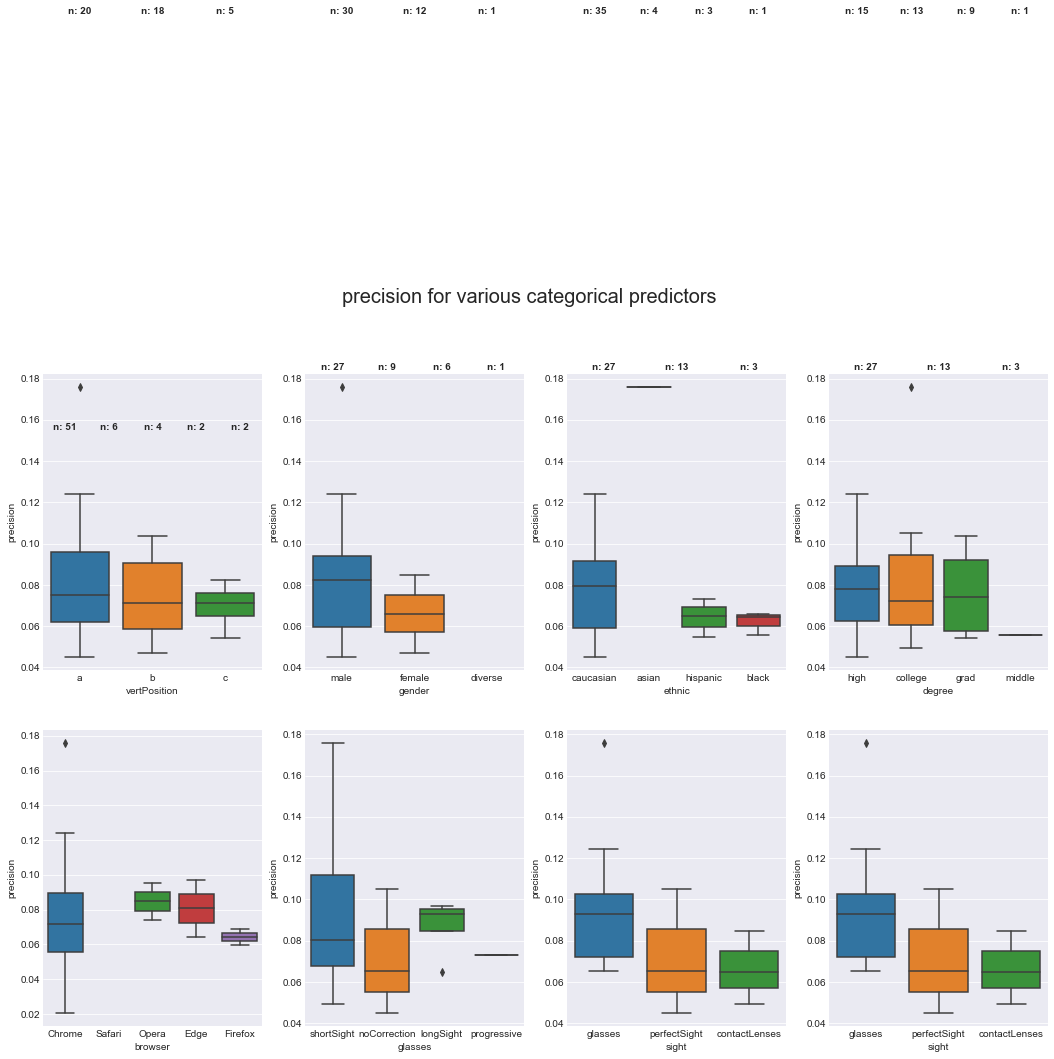

In [70]:
getBoxPlots('precision', yPos=0.36)

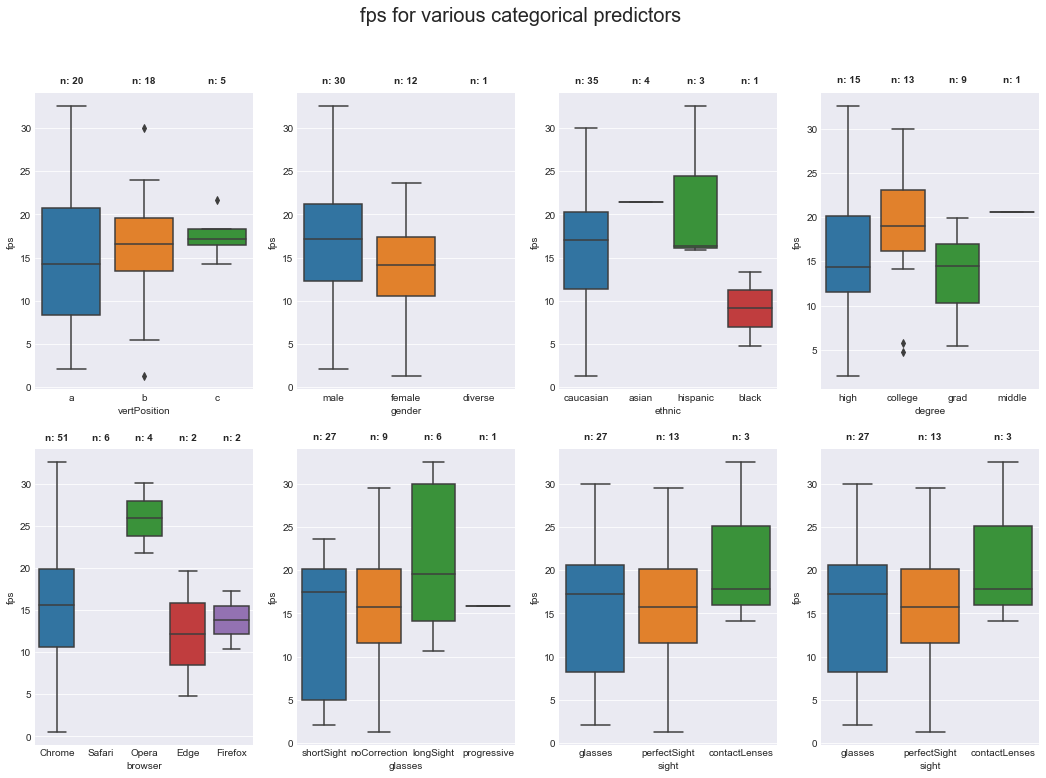

In [71]:
getBoxPlots('fps', yPos=36)

## Correlation Plot

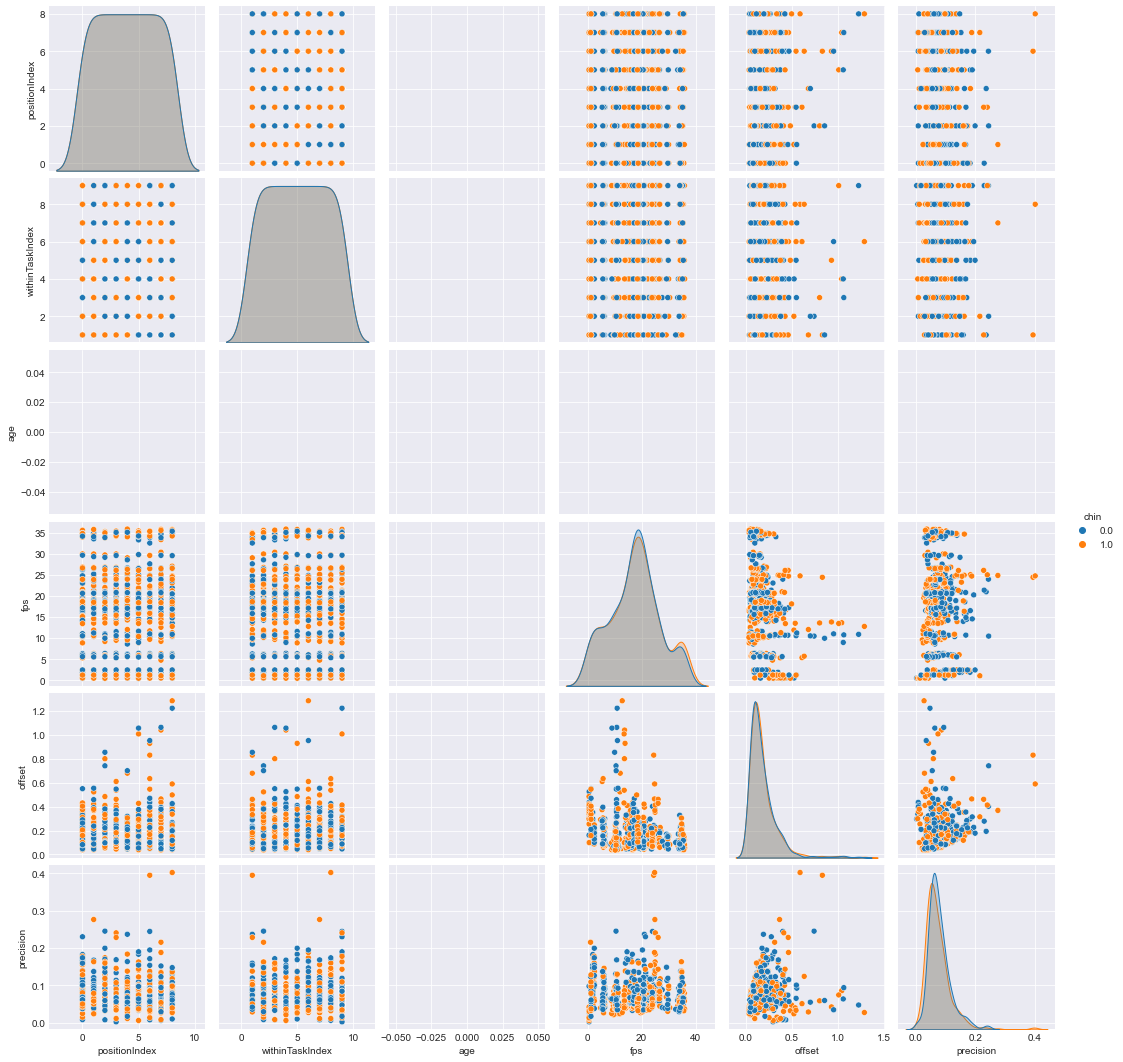

In [72]:
data_plot = data_trial_fix.merge(data_subject.loc[:, ['run_id', 'age']], on='run_id', how='left')
correlation_columns = ['positionIndex', 'withinTaskIndex', 'age', 'fps', 'offset', 'precision']
sns.pairplot(data_plot.loc[:, np.append(correlation_columns, ['chin'])], hue='chin')

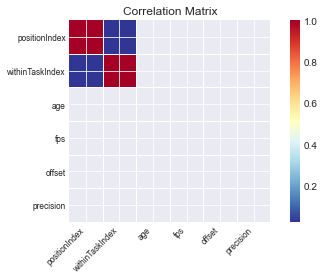

In [73]:
corr_matrix = np.corrcoef(data_plot[correlation_columns].T)
smg.plot_corr(corr_matrix, xnames=correlation_columns)
plt.show()

In [74]:
data_plot[correlation_columns].rcorr()

,positionIndex,withinTaskIndex,age,fps,offset,precision
positionIndex,-,,,,,**
withinTaskIndex,0.026,-,,,,
age,nan,nan,-,,,
fps,-0.002,-0.0,nan,-,***,
offset,0.012,0.01,nan,-0.274,-,***
precision,-0.112,0.037,nan,0.024,0.215,-


In [75]:
data_plot[correlation_columns].rcorr(upper='n')

ValueError: Cannot convert non-finite values (NA or inf) to integer

# MLA Model

In [ ]:
data_plot = data_trial_fix.loc[:, ['run_id', 'chin', 'x_pos', 'y_pos', 'precision']]
null_data = data_plot.loc[data_plot.isnull().any(axis=1), :]
data_plot = data_plot.loc[pd.notna(data_plot['precision']), :].reset_index(drop=True)
data_plot.loc[data_plot.isnull().any(axis=1), :]
model = smf.mixedlm("precision ~ x_pos", data_plot, groups=data_plot["run_id"])
model_fit = model.fit()
print(model_fit.summary())

# Export

In [ ]:
data_et_calibration.to_csv("data_jupyter/data_et_calibration.csv", index=False, header=True)
data_trial_calibration.to_csv("data_jupyter/data_trial_calibration.csv", index=False, header=True)

data_et_fix.to_csv("data_jupyter/data_et_fix.csv", index=False, header=True)
data_trial_fix.to_csv("data_jupyter/data_trial_fix.csv", index=False, header=True)

data_subject.to_csv("data_jupyter/data_subject.csv", index=False, header=True)

# Feedback

In [ ]:
print('Success! Script ran through')